# Data generation

In [85]:
import numpy as np
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi
from arma import matrix

days = 100  
obs_per_day = 1
nobs = days * obs_per_day
MAGI_niter = 15001
X = np.arange(0, days, 1./obs_per_day)
true_lambda = np.repeat(36, nobs)
true_rho = np.repeat(0.108, nobs) 
k = 5e-4
true_gamma = np.cos(3.14 * X / 500)
true_delta = np.repeat(0.1, nobs) 
N = 1000.
c = 3.5

def gen_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day, state0=[350., 20., 1200.],N=N, k=k, c=c, linspace=1000, noise=True):
    """
    generate data using pre-set parameters 
    """
    # check input
    # [ S, E, I, D, cfr0]
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 3))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = int(i / linspace)
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (true_lambda[index] - true_rho[index] * state_ls[i - 1][0] - k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2] - true_delta[index] * state_ls[i - 1][1])
        state_ls[i][2] = state_ls[i - 1][2] + step_size * (N * true_delta[index] * state_ls[i - 1][1] - c * state_ls[i - 1][2]) 
    states = state_ls[::obs_per_day * linspace]
    if noise == True:
        yobs = states.copy()
        yobs[:, 2] = states[:, 2] * np.random.normal(np.repeat(1., nobs), np.linspace(0.03, 0.03, nobs))

    return yobs[:, 0], np.log(yobs[:, 2].reshape(-1, 1)), states


Tt, yobs, true_x = gen_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day, noise=True)

In [86]:
obs_per_day=1
discretization=1
theta_lowerbound=np.array([-np.inf, -np.inf])
theta_upperbound=np.array([np.inf, np.inf])
MAGI_niter=15001
param_names = ['alpha_1', 'alpha_2']
is_time_varying=[True, True]
pointwise_niter=150000
kernel_niter=60000
TVMAGI_niter=150000
phi1_lb_ls=np.array([0.1, 0.1])
phi2_lb_ls=np.array([0.1, 0.1])
use_trajectory='observation'
learning_rate=np.array([1e-5, 1e-3, 1e-4])

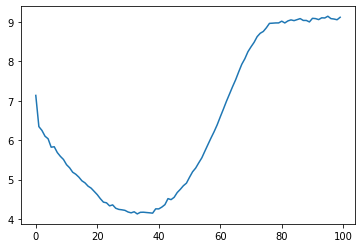

In [87]:
import matplotlib.pyplot as plt
plt.plot(yobs)

# First step

In [88]:
def fOde(theta, x):
    """
    theta: list[2]: 
    """
    global Tt
    logX = x[:, 0]
    logXdt = 1e5 * theta[0] * np.exp(-logX) + 1e3 * theta[1] * Tt * np.exp(-logX) - 3.5
    return np.stack([logXdt], axis=1)

def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[2]
    x: array(n, 1)
    r: array(n, 1, 1)
    """
    global Tt
    resultDx = np.zeros(shape=[np.shape(x)[0], 1, 1])
    logX = x[:, 0]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (0) / dlogT
    resultDx[:, 0, 0] = -1e5 * theta[0] * np.exp(-logX) - 1e3 * theta[1] * Tt * np.exp(-logX)
    return resultDx

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

def fOdeDtheta(theta, x):
    """
    returns derivation of theta given X
    theta: list[2]
    x: array(n, 1)
    r: array(n, 2, 1)
    """
    global Tt
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 2, 1])
    logX = x[:, 0]
    # [:, i, j]: 第j个方程对theta_i求导
    # (0) / 0
    resultDtheta[:, 0, 0] = 1e5 * np.exp(-logX)
    # (0) / 1
    resultDtheta[:, 1, 0] = 1e3 * Tt * np.exp(-logX)
    return resultDtheta

nobs, p_dim = yobs.shape[0], yobs.shape[1]
days = nobs / obs_per_day
n_points = nobs * discretization
theta_dim = theta_lowerbound.shape[0]
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
# First stage: use MAGI package to optimize theta as constant
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=MAGI_niter,
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(MAGI_niter * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
        each_pycov = dict(
            Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
            Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
            mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
        )
        CovAllDimensionsPyList.append(each_pycov)

In [91]:
inferred_theta
# yobs.shape

array([ 0.17843542, -0.05052071])

# Second step

In [90]:
Tt_torch = torch.tensor(Tt)

def fOdeTorch(theta, x, c=3.5, k=5e-4, N=1000.):
    global Tt_torch
    logX = x[:, 0]
    logXdt = 1e5 * theta[:, 0] * torch.exp(-logX) + 1e3 * theta[:, 1] * Tt_torch * torch.exp(-logX) - 3.5
    return torch.stack([logXdt], axis=1)


def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature,
                                 obs_per_day):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)

# Second stage, pointwise estimation of theta
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1

if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == 0:
        param_name = param_names[thetaEachDim]
        locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=learning_rate[0])  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=100000, gamma=0.2)
for epoch in range(300000):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                        TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature, obs_per_day)
    loss = -llik
    if epoch % 100 == 0:
        print(epoch, loss.item())
    loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

0 619774796.9539174
100 175028094.89009008
200 43061325.62261668
300 17891343.953707363
400 14394762.30015903
500 13568905.68914912
600 13011543.24261942
700 12517511.116088776
800 12060987.788154611
900 11632665.48737277
1000 11227470.147157181
1100 10842113.205432635
1200 10474206.506673098
1300 10121894.798891429
1400 9783679.209277647
1500 9458318.114368511
1600 9144764.643744858
1700 8842124.419580394
1800 8549625.643180389
1900 8266597.124075496
2000 7992451.59946606
2100 7726672.686891718
2200 7468804.403779063
2300 7218442.551786433
2400 6975227.499763972
2500 6738838.056317757
2600 6508986.226067008
2700 6285412.708068792
2800 6067883.032948085
2900 5856184.257085896
3000 5650122.144895434
3100 5449518.777954183
3200 5254210.534786601
3300 5064046.388667201
3400 4878886.473874583
3500 4698600.874146232
3600 4523068.59116228
3700 4352176.655866855
3800 4185819.351115924
3900 4023897.52011281
4000 3866317.9409190845
4100 3712992.752652323
4200 3563838.9235868305
4300 3418777.755

34100 20.297191003650628
34200 27.376481971373252
34300 19.59684318855401
34400 23.58593973840989
34500 18.928077048950215
34600 28.23118707432169
34700 18.26686737071409
34800 40.46560302160635
34900 17.615838014099225
35000 17.405843981400174
35100 19.81507403264786
35200 46.93356470596831
35300 16.348741870500206
35400 16.4209930359431
35500 35.610020596588235
35600 16.24626185004983
35700 15.136103073761532
35800 14.846354554663273
35900 16.27253154980372
36000 172.71868400831232
36100 13.931949074804603
36200 13.706627175904204
36300 16.464101600855148
36400 13.122159394839159
36500 12.802690831567554
36600 25.340929037542956
36700 12.20489951735399
36800 13.48557491030093
36900 11.647197865399
37000 22.75309593246226
37100 11.09944868875865
37200 97.1535023491086
37300 10.560760012557287
37400 17.729996356256173
37500 159.73689673030788
37600 9.82132865696287
37700 9.526237635925348
37800 9.407548848464463
37900 11.857313662539482
38000 11.076090031030848
38100 8.461695312043958


66800 -43.891548366416025
66900 -39.94265364039533
67000 -30.46604818252874
67100 -44.82560369775769
67200 -45.815039439199474
67300 -43.20563873074941
67400 -46.15916647690214
67500 -46.38013336376602
67600 -46.2401606258863
67700 -46.747659555739105
67800 -3.44752434610524
67900 -47.11515431550605
68000 -47.30001481949923
68100 -44.43067785301346
68200 -47.66894410316347
68300 -47.85404869423955
68400 -41.168014380270535
68500 -48.22399308216233
68600 -48.40951337336771
68700 96.87715154185132
68800 -48.778952570945364
68900 -48.96689942256883
69000 -49.153480514348246
69100 -48.99210475688911
69200 -49.526654435369316
69300 -49.71401458829976
69400 -23.171422916128495
69500 -50.088032308051694
69600 -50.27745561926528
69700 -50.466222900937865
69800 -50.54960835802116
69900 -50.843349661139335
70000 -51.032647471562825
70100 173.8368005803048
70200 -51.406507110547665
70300 -51.60020832847781
70400 364.4589638073397
70500 -51.97085763609151
70600 -52.17007847452839
70700 204.6687359

99400 -127.26368892933236
99500 -126.51253266242861
99600 -128.02190894068661
99700 -124.88534578908492
99800 -128.78542993810504
99900 -128.3367169314897
100000 -118.56237563656808
100100 -129.63203472035372
100200 -129.70938836475133
100300 -129.78643638310385
100400 -129.86344353585383
100500 -129.94042790964932
100600 -130.0174061234088
100700 -130.0943935390324
100800 -130.17140439237443
100900 -130.24845197183092
101000 -130.32554871673258
101100 -130.4027063273553
101200 -130.47993586834758
101300 -130.55724787324831
101400 -130.63465237748807
101500 -130.71215902644983
101600 -130.7897771108085
101700 -130.867515623188
101800 -130.9453833179418
101900 -131.02338872287777
102000 -131.10154020169992
102100 -131.17984595488568
102200 -131.25831406992006
102300 -131.33695253315506
102400 -131.4157692180408
102500 -131.4947719441473
102600 -131.5739684340128
102700 -131.6533663543718
102800 -131.7329732930689
102900 -131.81279676325858
103000 -131.8928441960315
103100 -131.973122927

130200 -155.96412461730154
130300 -155.51780213997546
130400 -156.15962245215783
130500 -149.16952715448167
130600 -156.35539721853718
130700 -156.45378130097086
130800 -156.467657239005
130900 -156.6503959236145
131000 -156.61134742284614
131100 -156.8473735057394
131200 -156.612792079823
131300 -157.0447774016432
131400 -157.13708249387392
131500 -157.22935658312264
131600 -157.3407473968739
131700 -157.38082149533463
131800 -157.51584781208538
131900 -157.637834203319
132000 -157.64021918582216
132100 -157.83729240831937
132200 -157.93625623585027
132300 -158.03647534214096
132400 -158.1316226241169
132500 -158.23593113926654
132600 -158.29586563168667
132700 -158.41871538608933
132800 -158.52398722077683
132900 -158.63276164387466
133000 -158.72738595895257
133100 -158.42195441497734
133200 -158.9365683944558
133300 -158.16694166539511
133400 -159.13745274534438
133500 -157.32193390435404
133600 -159.33854132686042
133700 -159.4318320661537
133800 -159.53809175749674
133900 -159.64

161000 -189.75193892338888
161100 -190.70183440391696
161200 -184.47817381629187
161300 -190.96075714012616
161400 -191.0764306065677
161500 -191.21965347630925
161600 -191.3421751592212
161700 -191.48023148468775
161800 -191.61117830849903
161900 -191.73299495480063
162000 -191.8716908794066
162100 -187.1872009800967
162200 -192.13235383483465
162300 -192.26303836813685
162400 -192.12040988277593
162500 -192.52472097567485
162600 -192.6547579388011
162700 -192.7859945966459
162800 -192.36773001707138
162900 -193.0502351470981
163000 -192.66138133334277
163100 -193.31397682901093
163200 -192.49339289067854
163300 -193.5783637285037
163400 -193.4884628211804
163500 -193.84325285644067
163600 -193.91004755915654
163700 -194.10844638215482
163800 -194.23080884897672
163900 -193.97731167510992
164000 -193.60367924231184
164100 -194.3894259424234
164200 -194.77359399821177
164300 -194.89552433108386
164400 -188.06064581908973
164500 -195.17481720969764
164600 -194.034126003834
164700 -195.4

191700 -234.88932111429872
191800 -234.89076965015357
191900 -235.1632831078452
192000 -235.29966487497137
192100 -235.18603355034395
192200 -235.57068299068433
192300 -235.70545638718892
192400 -235.83956812178332
192500 -235.97246700397773
192600 -236.1055632241065
192700 -236.22771708437187
192800 -235.03459577160706
192900 -236.50333440380763
193000 -236.60550546038266
193100 -236.7648018132437
193200 -236.88985149192072
193300 -234.52323045999697
193400 -237.1524679259683
193500 -237.17074539995212
193600 -237.40790113954736
193700 -237.5233390716655
193800 -237.66059120254954
193900 -237.78134276511256
194000 -237.910216256328
194100 -238.03241645615432
194200 -238.03080312066274
194300 -238.27988451443952
194400 -238.40238707174495
194500 -238.40322530977792
194600 -238.6436574895161
194700 -238.76325456871086
194800 -238.8611362891318
194900 -238.99983788446661
195000 -239.06312820213026
195100 -239.2330564693431
195200 -239.34166651479183
195300 -239.01754982136734
195400 -237

222500 -245.1992610511668
222600 -245.2028715164103
222700 -245.20804677141612
222800 -245.212234014836
222900 -245.16759299895708
223000 -245.22118727704097
223100 -245.22368814031105
223200 -245.22993335936974
223300 -245.23433733772535
223400 -245.2156509624642
223500 -245.24309336497586
223600 -245.2261306586957
223700 -245.10358309514126
223800 -245.25619783169674
223900 -245.2600891737857
224000 -245.259089145177
224100 -245.25870316242197
224200 -245.27366468694893
224300 -245.2766045242947
224400 -245.27768948968355
224500 -245.2867168170608
224600 -245.10438937259448
224700 -245.29545775460602
224800 -245.2325026956269
224900 -245.3041478323158
225000 -245.30835316468188
225100 -245.31274558597278
225200 -245.3171599413739
225300 -245.32074691946644
225400 -245.32582609339863
225500 -245.25886547002082
225600 -245.33447893484885
225700 -245.338825827409
225800 -245.04074505755872
225900 -245.3474696865543
226000 -245.35179809447936
226100 -245.35613285196993
226200 -245.358682

253300 -246.48431149924082
253400 -246.37601286707178
253500 -246.49232737488154
253600 -246.48992125345782
253700 -246.5003429796626
253800 -246.5027458912029
253900 -246.50835465850437
254000 -246.50991878827406
254100 -246.5163588158488
254200 -246.517546103189
254300 -246.52436233275273
254400 -246.52811101402082
254500 -246.53233778454654
254600 -246.5362711189511
254700 -246.50948333256378
254800 -246.54435451971474
254900 -246.54607123221072
255000 -246.55235429529105
255100 -246.55596377427415
255200 -246.51528468847897
255300 -246.5643434636928
255400 -246.56735803110513
255500 -246.57142557064918
255600 -246.57629860007123
255700 -246.52192952311322
255800 -246.58430061502662
255900 -246.58516632589442
256000 -246.59227699608374
256100 -246.59136351654445
256200 -246.600250418328
256300 -246.5872712518392
256400 -246.60819718092847
256500 -246.43887843345945
256600 -246.6161910251915
256700 -246.60843320285645
256800 -246.62266502612624
256900 -246.62809734324696
257000 -246.

284100 -247.6815614278602
284200 -247.68539785727265
284300 -247.61327698661754
284400 -247.69292567505786
284500 -247.6966934493894
284600 -247.3063892952269
284700 -247.70421986614298
284800 -247.70799540510242
284900 -247.64743773222534
285000 -247.71552288688758
285100 -247.71928759382752
285200 -247.70981002846895
285300 -247.7268082866721
285400 -247.73056597610477
285500 -247.7340947698731
285600 -247.7380871413894
285700 -247.67270831135417
285800 -247.74559441359654
285900 -247.74937128308488
286000 -247.5918463976134
286100 -247.75688998426563
286200 -247.7606540732902
286300 -247.71884165614694
286400 -247.7681650918334
286500 -247.7719176728125
286600 -247.76113795039294
286700 -247.77941794244902
286800 -247.78316933132214
286900 -247.7846816162319
287000 -247.79067181664973
287100 -247.7943642696979
287200 -247.68880593661785
287300 -247.801772629215
287400 -247.80565965021927
287500 -247.80579352392252
287600 -247.78817780350184
287700 -247.8169439967606
287800 -247.8205

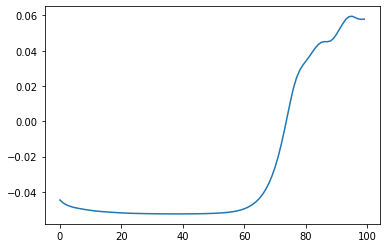

In [92]:
import matplotlib.pyplot as plt

pointwise_theta = pointwise_theta_torch.detach().numpy()
plt.plot(pointwise_theta[:, 1])

In [93]:
def MaternKernel(d, phi_1, phi_2):
    """
    construct a kernel given time points and hyper parameters
    """
    a = torch.square(phi_1) * (
            1. + np.sqrt(5) * d / phi_2 + 5. * torch.square(d) / (3. * torch.square(phi_2))) * torch.exp(
        -np.sqrt(5) * d / phi_2)
    return a.double()


def kernelllik(phi_1, phi_2, sigma, y, d_matrix, phi1_lb=0.1, phi2_lb=10., sigma_lb = 0.03):
    """
    optimize the kernel hyperparameters by maximizing marginal likelihood
    """
    phi_1_bounded = torch.clamp(phi_1, min=phi1_lb)
    phi_2_bounded = torch.clamp(phi_2, min=phi2_lb)
    sigma_bounded = torch.clamp(sigma, min=sigma_lb)
    K = MaternKernel(d_matrix, phi_1, phi_2)
    K += torch.square(sigma) * torch.eye(y.shape[0]).double()
    return -y.shape[0] * np.log(np.sqrt(2 * np.pi)) - 0.5 * y @ torch.inverse(K) @ y - 0.5 * torch.logdet(K) - 1e8 * torch.square(phi_1 - phi_1_bounded) - 1e6 * torch.square(phi_2 - phi_2_bounded) - 1e6 * torch.square(sigma - sigma_bounded)


pointwise_theta = pointwise_theta_torch.detach().numpy()
# theta_true_torch = torch.tensor(theta_true)
hyperparamList = []
phi1_lb_ls=np.array([0.1, 0.1, 0.1])
phi2_lb_ls=np.array([5., 5., 5.])
kernel_niter=20000
# optimize the hyperparameters of kernels
for thetaEachDimension in range(pointwise_theta.shape[1]):
    phi_1 = torch.tensor(1., requires_grad=True, dtype=torch.double)
    phi_2 = torch.tensor(15.0, requires_grad=True, dtype=torch.double)
    sigma = torch.tensor(0.05, requires_grad=True, dtype=torch.double)
    kernel_optimizer = torch.optim.Adam([phi_1, phi_2, sigma], lr=learning_rate[1])
    for epoch in range(kernel_niter):
        kernel_optimizer.zero_grad()
        loss = -kernelllik(phi_1, 
                           phi_2, 
                           sigma, 
                           pointwise_theta_torch[:, thetaEachDimension] - torch.mean(pointwise_theta_torch[:, thetaEachDimension]), 
                           d_matrix, 
                           phi1_lb_ls[thetaEachDimension], 
                           phi2_lb_ls[thetaEachDimension])
        loss.backward()
        kernel_optimizer.step()
        if epoch % 100 == 0:
            print(epoch, loss.item())
    print(phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item())
    hyperparamList.append([phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()])

KthetaList = []
KinvthetaList = []
for thetaEachDimension in range(pointwise_theta.shape[1]):
    ker = MaternKernel(d_matrix, torch.tensor(hyperparamList[thetaEachDimension][0]), torch.tensor(hyperparamList[thetaEachDimension][1]))
    KthetaList.append(ker)
    KinvthetaList.append(torch.inverse(ker))

0 -152.00321731538185
100 -194.1230750661508
200 -197.97366789280795
300 -202.24852178935055
400 -207.15739073915523
500 -213.07305857416404
600 -220.84078292371566
700 -233.34610959636396
800 -236.35354739564121
900 -236.729143387807
1000 -237.14357994340548
1100 -237.59823862476452
1200 -238.09621642658138
1300 -238.64126385742028
1400 -238.75265819124732
1500 -238.99102241074132
1600 -238.9814230382368
1700 -239.05911646532445
1800 -238.97314503519107
1900 -239.12045865697561
2000 -239.21566962203465
2100 -239.04528045269572
2200 -239.1315025172359
2300 -239.30796725259566
2400 -239.19407666447512
2500 -239.2277463316359
2600 -239.0478803145219
2700 -239.47811189545345
2800 -239.48519323394228
2900 -239.4154221356304
3000 -239.77817538261098
3100 -239.70826307736016
3200 -239.88655617185884
3300 -240.00136995942347
3400 -239.55213432612828
3500 -239.96085819042017
3600 -239.56787198085274
3700 -239.50045268890094
3800 -239.48946788546525
3900 -240.10139788620356
4000 -239.6629382944

12600 -243.8851613086045
12700 -243.9150136675338
12800 -244.07857725473735
12900 -243.91216780886805
13000 -244.07752599959753
13100 -244.2840492937468
13200 -244.0810485441717
13300 -243.83232239694343
13400 -244.45660125327834
13500 -243.96927598027895
13600 -244.5851082109965
13700 -244.37261442573407
13800 -244.14378993213975
13900 -244.52660577790357
14000 -244.43421136371427
14100 -244.30845028229615
14200 -244.61185828003534
14300 -244.49096686691811
14400 -244.47702878667047
14500 -244.6650194667066
14600 -244.4603165765473
14700 -244.13791182350982
14800 -244.68705130480973
14900 -244.411608757165
15000 -244.75387149227933
15100 -244.86461327696043
15200 -244.23419928568742
15300 -244.7678567200567
15400 -244.90021293750834
15500 -244.80120484996735
15600 -245.05357921735097
15700 -244.89214875840494
15800 -245.0129843787521
15900 -245.0210843753163
16000 -245.09014189394918
16100 -245.1575698895795
16200 -244.7281314832583
16300 -245.29972618585592
16400 -244.72780892258893


In [22]:
time_constant_param_ls
pointwise_theta_torch.shape

torch.Size([64, 3])

# Third stage

In [94]:
def xthetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                         priorTemperature,
                         KinvthetaList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    res2 = torch.zeros(1).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(
            (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ KinvthetaList[thetaEachDim] @ (
                    theta[:, thetaEachDim] - inferred_theta[thetaEachDim]))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return torch.sum(res) + torch.sum(res_theta)

TVMAGI_xlatent_torch = torch.tensor(pointwise_xlatent_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
TVMAGI_theta_torch = torch.tensor(pointwise_theta_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
TVMAGI_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
TVMAGI_optimizer = torch.optim.Adam([TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch] + time_constant_param_ls, lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(TVMAGI_optimizer, step_size=10000, gamma=0.2)
LossVal = np.zeros(300000)
for epoch in range(300000):
    TVMAGI_optimizer.zero_grad()
    # compute loss function
    llik = xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch, time_constant_param_ls, TVMAGI_sigma_torch,
                                                TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                priorTemperature, KinvthetaList)
    loss = -llik
    if epoch % 100 == 0:
        print(epoch, loss.item())
    LossVal[epoch] = loss.item()
    loss.backward()
    TVMAGI_optimizer.step()
    lr_scheduler.step()

0 137.46912101018015
100 98.48343704173713
200 81.74302273854197
300 71.31081046610781
400 64.31265960924887
500 59.49281141055168
600 56.088701981451806
700 53.62646128828496
800 51.73750906429376
900 50.26156715291664
1000 49.08306520220161
1100 48.06456356889859
1200 47.21014731176194
1300 46.89346646699842
1400 45.846792230411225
1500 46.34088687079449
1600 44.745665620440064
1700 46.161256431215634
1800 43.94282782429086
1900 44.077052911347444
2000 43.87257691730014
2100 45.79905355506468
2200 46.130923561232265
2300 245.79622982409694
2400 41.71443181299591
2500 41.80212086580546
2600 41.167699672624224
2700 40.79704975723633
2800 53.993308275634135
2900 40.1983034856338
3000 39.9026568375054
3100 40.554126666923295
3200 39.340563664186675
3300 181.02250464121457
3400 38.80064836477382
3500 38.527266587805244
3600 47.905576154796
3700 38.009401230762585
3800 37.90695878623242
3900 37.60762830318381
4000 37.26062511856418
4100 71.42988610506882
4200 36.892182886773504
4300 36.544

33900 22.187021367970985
34000 22.18393539171116
34100 22.18369826611611
34200 22.17779949822902
34300 22.174738293264916
34400 22.17712456452984
34500 22.168641414689063
34600 22.165619270290698
34700 22.163044358614876
34800 22.159574080613915
34900 22.156562723241755
35000 22.153649193860264
35100 22.150572925365402
35200 22.14757987791144
35300 22.144616941224744
35400 22.141617208578683
35500 22.142465143719683
35600 22.135664450856655
35700 22.136640850755768
35800 22.129742660643615
35900 22.127000874808175
36000 22.125087824876275
36100 22.120870041079286
36200 22.117921901224058
36300 22.115054608753255
36400 22.11224462371266
36500 22.113824856855764
36600 22.106160515693393
36700 22.103235004497616
36800 22.10277204620804
36900 22.09738765615746
37000 22.094707403707233
37100 22.091562733604842
37200 22.088820633460482
37300 22.08575500350687
37400 22.08291468584334
37500 22.079974281776863
37600 22.07715267999859
37700 22.07420177335855
37800 22.072624178969228
37900 22.068

67200 21.91224688732636
67300 21.912208896396105
67400 21.912170822967823
67500 21.912132626023283
67600 21.912094566169827
67700 21.912056570668522
67800 21.91201847674303
67900 21.911980438162153
68000 21.911942462623458
68100 21.911904463381507
68200 21.911866447965195
68300 21.911828417956066
68400 21.91179037110173
68500 21.911752338133958
68600 21.911714374326188
68700 21.911676433290992
68800 21.911638461619514
68900 21.911600578506214
69000 21.91156276258451
69100 21.911524815609386
69200 21.911487083546813
69300 21.911449345956974
69400 21.911411568126752
69500 21.911373795744346
69600 21.911336022868003
69700 21.911298261443797
69800 21.911260477927243
69900 21.911222715206108
70000 21.911185010541104
70100 21.91117745592234
70200 21.911169874354343
70300 21.911162265835483
70400 21.91115464824457
70500 21.911146974234484
70600 21.911139289264618
70700 21.911131586364817
70800 21.911123831577896
70900 21.911116062016458
71000 21.911108282714746
71100 21.911100453930686
71200 

100500 21.91018247786856
100600 21.910182407579647
100700 21.910182335857222
100800 21.910182281774993
100900 21.910182210122834
101000 21.910182135351377
101100 21.91018207625548
101200 21.910182010156404
101300 21.910181951566862
101400 21.91018187505592
101500 21.91018181304311
101600 21.910181742202273
101700 21.910181692774085
101800 21.910181610267305
101900 21.910181549963216
102000 21.910181485584694
102100 21.91018140784457
102200 21.91018136318117
102300 21.91018128112199
102400 21.910181202338457
102500 21.910181136671884
102600 21.910181082668387
102700 21.910181026920768
102800 21.91018094939258
102900 21.910180889475598
103000 21.910180820511826
103100 21.910180743771118
103200 21.910180683926725
103300 21.91018061204077
103400 21.910180546160213
103500 21.91018048567825
103600 21.910180421979806
103700 21.910180343312682
103800 21.910180278064622
103900 21.910180224329746
104000 21.910180151950403
104100 21.910180089556867
104200 21.91018003263906
104300 21.9101799559125

132500 21.91017458240538
132600 21.9101745866843
132700 21.91017457093677
132800 21.91017458674744
132900 21.910174587555556
133000 21.910174570134732
133100 21.91017456979413
133200 21.910174572567435
133300 21.91017458613191
133400 21.91017458089372
133500 21.910174583915158
133600 21.9101745807666
133700 21.91017457365283
133800 21.910174585683873
133900 21.910174585525244
134000 21.91017457144709
134100 21.91017457539931
134200 21.910174573286987
134300 21.910174576839985
134400 21.91017456656688
134500 21.910174567453936
134600 21.910174580409247
134700 21.910174576956386
134800 21.91017456710823
134900 21.910174562868118
135000 21.91017456230082
135100 21.910174572306346
135200 21.910174564452326
135300 21.9101745581968
135400 21.91017457854214
135500 21.910174564225137
135600 21.910174571842557
135700 21.910174558843106
135800 21.910174568076954
135900 21.910174566324088
136000 21.91017456462393
136100 21.910174564894866
136200 21.910174575080596
136300 21.910174560638325
136400

164600 21.91017453223015
164700 21.910174534583035
164800 21.91017453539808
164900 21.91017452693329
165000 21.910174535499465
165100 21.910174537557637
165200 21.910174530147188
165300 21.910174530934718
165400 21.91017452724538
165500 21.910174535340936
165600 21.910174524843697
165700 21.910174538178147
165800 21.910174533721893
165900 21.910174533490384
166000 21.910174525286415
166100 21.910174523295893
166200 21.910174536920028
166300 21.910174526435803
166400 21.910174540032425
166500 21.9101745244428
166600 21.91017452045183
166700 21.91017453419361
166800 21.910174534242522
166900 21.91017453202135
167000 21.910174510454127
167100 21.910174536321932
167200 21.910174519645636
167300 21.91017453449635
167400 21.910174533478504
167500 21.910174529980114
167600 21.910174533426115
167700 21.910174520165
167800 21.910174524555213
167900 21.910174532785366
168000 21.91017453649191
168100 21.91017452766684
168200 21.910174542827285
168300 21.910174534789657
168400 21.91017453006419
16

196600 21.910174530227454
196700 21.910174529961083
196800 21.91017453119286
196900 21.91017452976707
197000 21.910174528332966
197100 21.910174530998013
197200 21.910174529365428
197300 21.910174529556066
197400 21.910174530960916
197500 21.910174529925943
197600 21.910174529292853
197700 21.91017453174907
197800 21.91017453075527
197900 21.910174530270453
198000 21.910174530009847
198100 21.910174529720823
198200 21.91017452993861
198300 21.910174531079676
198400 21.910174530974864
198500 21.91017453028182
198600 21.91017453087582
198700 21.91017453208293
198800 21.910174530174764
198900 21.91017453141238
199000 21.91017452979728
199100 21.910174529971464
199200 21.91017453080588
199300 21.91017452899638
199400 21.91017452939397
199500 21.910174530297628
199600 21.91017452758046
199700 21.91017452925015
199800 21.910174529443736
199900 21.91017452880463
200000 21.910174529184673
200100 21.910174529184673
200200 21.910174529184673
200300 21.910174529184673
200400 21.910174529184673
20

228200 21.910174529184673
228300 21.910174529184673
228400 21.910174529184673
228500 21.910174529184673
228600 21.910174529184673
228700 21.910174529184673
228800 21.910174529184673
228900 21.910174529184673
229000 21.910174529184673
229100 21.910174529184673
229200 21.910174529184673
229300 21.910174529184673
229400 21.910174529184673
229500 21.910174529184673
229600 21.910174529184673
229700 21.910174529184673
229800 21.910174529184673
229900 21.910174529184673
230000 21.910174529184673
230100 21.910174529184673
230200 21.910174529184673
230300 21.910174529184673
230400 21.910174529184673
230500 21.910174529184673
230600 21.910174529184673
230700 21.910174529184673
230800 21.910174529184673
230900 21.910174529184673
231000 21.910174529184673
231100 21.910174529184673
231200 21.910174529184673
231300 21.910174529184673
231400 21.910174529184673
231500 21.910174529184673
231600 21.910174529184673
231700 21.910174529184673
231800 21.910174529184673
231900 21.910174529184673
232000 21.91

259800 21.910174529184673
259900 21.910174529184673
260000 21.910174529184673
260100 21.910174529184673
260200 21.910174529184673
260300 21.910174529184673
260400 21.910174529184673
260500 21.910174529184673
260600 21.910174529184673
260700 21.910174529184673
260800 21.910174529184673
260900 21.910174529184673
261000 21.910174529184673
261100 21.910174529184673
261200 21.910174529184673
261300 21.910174529184673
261400 21.910174529184673
261500 21.910174529184673
261600 21.910174529184673
261700 21.910174529184673
261800 21.910174529184673
261900 21.910174529184673
262000 21.910174529184673
262100 21.910174529184673
262200 21.910174529184673
262300 21.910174529184673
262400 21.910174529184673
262500 21.910174529184673
262600 21.910174529184673
262700 21.910174529184673
262800 21.910174529184673
262900 21.910174529184673
263000 21.910174529184673
263100 21.910174529184673
263200 21.910174529184673
263300 21.910174529184673
263400 21.910174529184673
263500 21.910174529184673
263600 21.91

291400 21.910174529184673
291500 21.910174529184673
291600 21.910174529184673
291700 21.910174529184673
291800 21.910174529184673
291900 21.910174529184673
292000 21.910174529184673
292100 21.910174529184673
292200 21.910174529184673
292300 21.910174529184673
292400 21.910174529184673
292500 21.910174529184673
292600 21.910174529184673
292700 21.910174529184673
292800 21.910174529184673
292900 21.910174529184673
293000 21.910174529184673
293100 21.910174529184673
293200 21.910174529184673
293300 21.910174529184673
293400 21.910174529184673
293500 21.910174529184673
293600 21.910174529184673
293700 21.910174529184673
293800 21.910174529184673
293900 21.910174529184673
294000 21.910174529184673
294100 21.910174529184673
294200 21.910174529184673
294300 21.910174529184673
294400 21.910174529184673
294500 21.910174529184673
294600 21.910174529184673
294700 21.910174529184673
294800 21.910174529184673
294900 21.910174529184673
295000 21.910174529184673
295100 21.910174529184673
295200 21.91

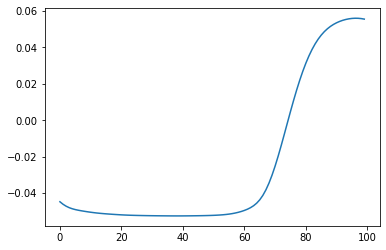

In [99]:
import matplotlib.pyplot as plt

TVMAGI_theta = TVMAGI_theta_torch.detach().numpy()
plt.plot(TVMAGI_theta[:, 1])

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0

# HMC

In [111]:
def vectorize(xlatent, theta, sigma, time_constant_param_ls):
    t1 = torch.reshape(xlatent.detach(), (-1,))
    t2 = torch.reshape(theta.detach(), (-1,))
    t3 = torch.reshape(sigma.detach(), (-1,))
    long_vec = torch.cat((t1, t2, t3))
    for i in range(len(time_constant_param_ls)):
        long_vec = torch.cat((long_vec, time_constant_param_ls[i].detach()))
    return long_vec

def get_dim(tensor_shape):
    if len(tensor_shape) == 0:
        return 1
    if len(tensor_shape) == 1:
        return tensor_shape[0]
    dim = 1
    for i in range(len(tensor_shape)):
        dim *= tensor_shape[i]
    return dim
    
def devectorize(long_tensor, xlatent_shape, theta_shape, sigma_shape, time_constant_param_dim):
    x_latent_dim = get_dim(xlatent_shape)
    theta_dim = get_dim(theta_shape)
    sigma_dim = get_dim(sigma_shape)
    time_constant_param_ls = []
    xlatent = torch.reshape(long_tensor[:x_latent_dim],xlatent_shape)
    theta = torch.reshape(long_tensor[x_latent_dim:x_latent_dim + theta_dim],theta_shape)
    sigma = torch.reshape(long_tensor[x_latent_dim + theta_dim:x_latent_dim + theta_dim + sigma_dim],sigma_shape)
    for each in range(x_latent_dim + theta_dim + sigma_dim, long_tensor.shape[0]):
        time_constant_param_ls.append(torch.tensor([long_tensor[each]]))
    return xlatent, theta, sigma, time_constant_param_ls


def NegLogLikelihood(xlatent, theta, time_constant_param_ls, sigma, 
                     inferred_theta = inferred_theta, 
                     ydata = ydata, 
                     CovAllDimensionsPyList = CovAllDimensionsPyList, 
                     fOdeTorch = fOdeTorch,
                     priorTemperature = priorTemperature, 
                     KinvthetaList = KinvthetaList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(
            (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ KinvthetaList[thetaEachDim] @ (
                    theta[:, thetaEachDim] - inferred_theta[thetaEachDim]))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return -(torch.sum(res) + torch.sum(res_theta))

class HMC:
    def __init__(self, negllik, all_theta, xlatent_shape, theta_shape, sigma_shape, time_constant_param_ls, lsteps=50, epsilon=1e-6, n_samples=4000, upper_bound = None, lower_bound = None, burn_in_ratio = 0.5):
        self.all_theta = all_theta
        self.theta_shape = theta_shape
        self.xlatent_shape = xlatent_shape
        self.sigma_shape = sigma_shape
        self.constant_dim = len(time_constant_param_ls)
        self.lsteps = lsteps
        self.epsilon = epsilon * torch.ones(all_theta.shape)
        self.burn_in_ratio = burn_in_ratio
        self.n_samples = n_samples
        self.total_samples = int(n_samples / (1 - burn_in_ratio))
        self.NegLogLikelihood = negllik
        self.ub = upper_bound
        if upper_bound is not None:
            if upper_bound.shape[0] != all_theta.shape[0]:
                raise ValueError
        self.lb = lower_bound
        if lower_bound is not None:
            if lower_bound.shape[0] != all_theta.shape[0]:
                raise ValueError
    
    def NegLogLikelihood_vec(self, all_theta):
        xlatent_0, theta_0, sigma_0, constant_param_ls_0 = devectorize(all_theta, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
        return NegLogLikelihood(xlatent_0, theta_0, constant_param_ls_0, sigma_0)
    
    def Nabla(self, theta_torch):
        theta_torch = theta_torch.detach()
        xlatent, theta, sigma, constant_param_ls = devectorize(theta_torch, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
        xlatent.requires_grad = True  
        theta.requires_grad = True
        sigma.requires_grad = True
        for each in constant_param_ls:
            each.requires_grad = True                      
        llik = self.NegLogLikelihood(xlatent, theta, constant_param_ls, sigma)
        llik.backward()
        constant_param_deriv_ls = []
        for each in constant_param_ls:
            constant_param_deriv_ls.append(each.grad)
        v = vectorize(xlatent.grad, theta.grad, sigma.grad, constant_param_deriv_ls)
        return v
    def sample(self, all_theta, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, KinvthetaList, temperature=1.):
        def bounce(m, lb, ub):
            if lb is None and ub is None:
                return m
            if lb is None:
                max_tensor = torch.clamp(m - ub, min=0)
                return m - 2 * max_tensor
            if ub is None:
                min_tensor = torch.clamp(lb - m, min=0)
                return m + 2 * min_tensor
            if torch.sum(lb < ub) < m.shape[0]:
                raise ValueError
            if torch.sum(m >= lb) == m.shape[0] and torch.sum(m <= ub) == m.shape[0]:
                return m
            if torch.sum(m >= lb) < m.shape[0]:
                min_tensor = torch.clamp(lb - m, min=0)
                return bounce(m + 2 * min_tensor, lb, ub)
            if torch.sum(m <= ub) < m.shape[0]:
                max_tensor = torch.clamp(m - ub, min=0)
                return bounce(m - 2 * max_tensor, lb, ub)

        trace_val = np.zeros(self.total_samples)
        samples = np.zeros((self.total_samples, self.all_theta.shape[0]))
        random_ls = np.random.uniform(0, 1, self.total_samples)
        acceptance_ls = np.zeros(self.total_samples)
        nan_ls = np.zeros(self.total_samples)
        cur_theta = self.all_theta.clone().detach()
        for EachIter in range(self.total_samples): ############
            if EachIter % 100 == 0 and EachIter > 90:
                print(EachIter)
                print(cur_nllik)
            cur_nllik_1 = self.NegLogLikelihood_vec(cur_theta).detach()
            rstep = torch.rand(self.epsilon.shape) * self.epsilon + self.epsilon
            p = torch.normal(mean=0., std=torch.ones(self.all_theta.shape))
            cur_p = p.clone()
            theta = cur_theta.clone()         
            p = p - rstep * self.Nabla(theta).clone() / 2
            for i in range(self.lsteps):
                theta = theta + rstep * p
                nabla_torch = self.Nabla(theta).clone()
                p = p - rstep * nabla_torch
                theta = bounce(theta, self.lb, self.ub)
            
            p = p - rstep * self.Nabla(theta).clone() / 2
            
            new_nllik = self.NegLogLikelihood_vec(theta)
            new_p = 0.5 * torch.sum(torch.square(p))
            new_H = new_nllik + new_p
            cur_nllik = self.NegLogLikelihood_vec(cur_theta).detach()
            cur_H = cur_nllik + 0.5 * torch.sum(torch.square(cur_p))
            
            if torch.isnan(theta[0]) or torch.isnan(new_H):
                samples[EachIter] = cur_theta.clone()
                nan_ls[EachIter] = 1
                self.epsilon *= 0.9
            else:
                # accept
                tmp = float(torch.exp(cur_H - new_H) / temperature)
                if  tmp > random_ls[EachIter]:
                    samples[EachIter] = theta.clone()
                    cur_theta = theta.clone()
                    acceptance_ls[EachIter] = 1
                # reject
                else:
                    samples[EachIter] = cur_theta.clone()
                    
            trace_val[EachIter] = self.NegLogLikelihood_vec(cur_theta).item()        

            if EachIter > 200 and EachIter < self.total_samples - self.n_samples:
                if np.sum(acceptance_ls[EachIter - 100 : EachIter]) < 60:
                    # decrease epsilon
                    self.epsilon *= 0.995
                if np.sum(acceptance_ls[EachIter - 100 : EachIter]) > 80:
                    # increase epsilon
                    self.epsilon *= 1.005
            if EachIter % 100 == 0 and EachIter > 100 and EachIter < self.total_samples - self.n_samples:
                print(EachIter)
                print(cur_nllik)
                print('acceptance rate: ', np.sum(acceptance_ls[EachIter - 100 : EachIter]) / 100)
                standard_deviation = torch.tensor(np.std(samples[EachIter - 100:EachIter, :], axis = 0))
                if torch.mean(standard_deviation) > 1e-6:
                    self.epsilon = 0.05 * standard_deviation * torch.mean(self.epsilon) / torch.mean(standard_deviation) + 0.95 * self.epsilon
        return samples, acceptance_ls, trace_val, nan_ls # [self.total_samples-self.n_samples:, :]

all_theta = vectorize(TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
# all_theta_true = vectorize(true_x_torch, theta_true_torch, sigma_torch, time_constant_param_ls)
# all_theta_pointwise = vectorize(pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch, time_constant_param_ls)
sampler = HMC(NegLogLikelihood, all_theta, 
              pointwise_xlatent_torch.shape,
              pointwise_theta_torch.shape, 
              sigma_torch.shape,
              time_constant_param_ls)
# sampler.Nabla(all_theta)
samples, b, c, d = sampler.sample(all_theta, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, KinvthetaList, temperature=10.)
# 
# print(sampler.NegLogLikelihood_vec(all_theta))
# sampler.sample(all_theta)
# 20 l step
# epsilon random start epsilon to 2 epsilon

100
tensor(21.9102, dtype=torch.float64)
200
tensor(21.9102, dtype=torch.float64)
200
tensor(21.9102, dtype=torch.float64)
acceptance rate:  0.0
300
tensor(21.9102, dtype=torch.float64)
300
tensor(21.9102, dtype=torch.float64)
acceptance rate:  0.0
400
tensor(21.9102, dtype=torch.float64)
400
tensor(21.9102, dtype=torch.float64)
acceptance rate:  0.0
500
tensor(50.2464, dtype=torch.float64)
500
tensor(50.2464, dtype=torch.float64)
acceptance rate:  0.01
600
tensor(66.6856, dtype=torch.float64)
600
tensor(66.6856, dtype=torch.float64)
acceptance rate:  0.06
700
tensor(72.0202, dtype=torch.float64)
700
tensor(72.0202, dtype=torch.float64)
acceptance rate:  0.13
800
tensor(74.0753, dtype=torch.float64)
800
tensor(73.9820, dtype=torch.float64)
acceptance rate:  0.07
900
tensor(73.9447, dtype=torch.float64)
900
tensor(73.9447, dtype=torch.float64)
acceptance rate:  0.11
1000
tensor(76.7213, dtype=torch.float64)
1000
tensor(78.0950, dtype=torch.float64)
acceptance rate:  0.07
1100
tensor(87.

In [112]:
all_theta = vectorize(TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
sampler.NegLogLikelihood_vec(all_theta)
# sampler.Nabla(all_theta)
sampler.epsilon

tensor([4.5028e-15, 4.1090e-15, 4.2344e-15, 4.7028e-15, 4.7061e-15, 4.1126e-15,
        4.5265e-15, 4.6587e-15, 4.3022e-15, 4.5328e-15, 4.7558e-15, 5.1097e-15,
        4.3346e-15, 4.3945e-15, 4.9443e-15, 4.7412e-15, 4.8008e-15, 4.9469e-15,
        4.8363e-15, 4.2101e-15, 4.2744e-15, 4.7258e-15, 4.5914e-15, 5.4579e-15,
        3.9990e-15, 4.8476e-15, 3.9980e-15, 4.2072e-15, 4.5375e-15, 4.2443e-15,
        4.5234e-15, 4.2909e-15, 4.6073e-15, 4.0554e-15, 4.3678e-15, 4.5325e-15,
        4.7439e-15, 4.2382e-15, 4.4681e-15, 5.0968e-15, 4.4662e-15, 4.9476e-15,
        4.4086e-15, 4.8453e-15, 4.9703e-15, 4.5704e-15, 4.3456e-15, 6.2616e-15,
        4.8035e-15, 4.4192e-15, 4.4935e-15, 4.6048e-15, 4.6007e-15, 4.2880e-15,
        4.7917e-15, 4.1526e-15, 4.0443e-15, 4.3294e-15, 4.2483e-15, 4.1093e-15,
        4.5176e-15, 5.1066e-15, 4.1915e-15, 4.9001e-15, 4.8137e-15, 4.3854e-15,
        4.2406e-15, 4.0472e-15, 4.0906e-15, 4.5610e-15, 5.1737e-15, 4.5808e-15,
        4.6362e-15, 4.2636e-15, 4.6451e-

In [101]:
xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch, time_constant_param_ls, TVMAGI_sigma_torch,
                                                TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                priorTemperature, KinvthetaList)
TVMAGI_theta_torch2 = TVMAGI_theta_torch + 1e-14 * torch.rand(TVMAGI_theta_torch.shape)
xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch2, time_constant_param_ls, TVMAGI_sigma_torch,
                                                TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                priorTemperature, KinvthetaList)

tensor(-21.9102, dtype=torch.float64, grad_fn=<AddBackward0>)

Text(0.5, 1.0, 'a2 (MAP, trained hyper)')

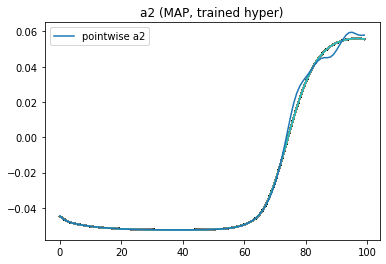

In [113]:
k = samples[4000:, 100:300]
val = np.zeros((100, 2))
for i in range(4000):
    for j in range(100):
        val[j] = k[i].reshape(-1, 2)[j]
    plt.plot(val[:, 1])
plt.plot(pointwise_theta[:, 1], label='pointwise a2')
# plt.plot(np.arange(0, 64, 2), true_re, label='true')
plt.legend()
plt.title('a2 (MAP, trained hyper)')

In [114]:
samples

array([[6.6932783 , 6.49592346, 6.30856729, ..., 0.28655402, 0.05552228,
        1.14180596],
       [6.6932783 , 6.49592346, 6.30856729, ..., 0.28655402, 0.05552228,
        1.14180596],
       [6.6932783 , 6.49592346, 6.30856729, ..., 0.28655402, 0.05552228,
        1.14180596],
       ...,
       [6.69329769, 6.49594624, 6.30851859, ..., 0.28649817, 0.05553727,
        1.14185574],
       [6.69329769, 6.49594624, 6.30851859, ..., 0.28649817, 0.05553727,
        1.14185574],
       [6.69329769, 6.49594624, 6.30851859, ..., 0.28649817, 0.05553727,
        1.14185574]])

100 1000 1
0.09056440672952402


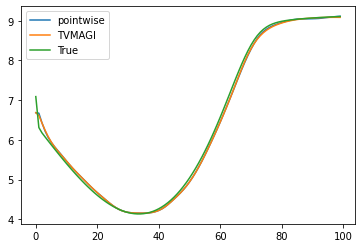

In [56]:
days = 100
def recover_data(a1, a2, Tt, state0=np.log(800.), linspace=1000, noise=True):
    """
    params: parameter: [re, pe, pi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    step_size = 1. / linspace
    state_ls = np.ones(days * linspace)
    state_ls[0] = state0
    for i in range(1, linspace * days):
        index = int(i / linspace)
        state_ls[i] = state_ls[i - 1] + step_size * (
                    1e5 * a1[index] * np.exp(-state_ls[i - 1]) + 1e3 * a2[index] * Tt[index] * np.exp(
                -state_ls[i - 1]) - 3.5)

    return state_ls[::linspace]

def gen_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day, state0=[350., 20., 1200.],N=N, k=k, c=c, linspace=1000, noise=True):
    """
    params: parameter: [re, pe, pi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    step_size = 1. / (linspace * obs_per_day)
    print(days,linspace,obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 3))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = int(i / linspace)
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (true_lambda[index] - true_rho[index] * state_ls[i - 1][0] - k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2] - true_delta[index] * state_ls[i - 1][1])
        state_ls[i][2] = state_ls[i - 1][2] + step_size * (N * true_delta[index] * state_ls[i - 1][1] - c * state_ls[i - 1][2]) 
    states = state_ls[::obs_per_day * linspace]

    return states[:, 0], states[:, 1], states[:, 2]


_, _, Yt = gen_data(true_lambda, true_rho, np.cos(3.14 * X / 500), true_delta, days=100, obs_per_day=1)
x1t = recover_data(pointwise_theta[:, 0], pointwise_theta[:, 1], Tt)
plt.plot(x1t, label='pointwise')
x2t = recover_data(TVMAGI_theta_torch[:, 0], TVMAGI_theta_torch[:, 1], Tt)
plt.plot(x2t, label='TVMAGI')
plt.plot(np.log(Yt), label='True')
plt.legend()
print(np.sqrt(np.sum(np.square(x2t - np.log(Yt))/100)))

Text(0.5, 1.0, 'HIV - HMC Trace Plot of Neg Log Likelihood (MAP)')

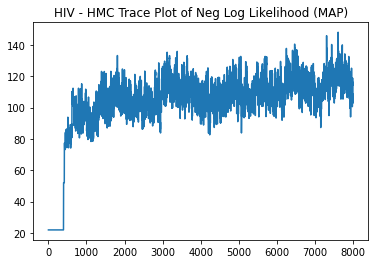

In [109]:
plt.plot(c)
plt.title('HIV - HMC Trace Plot of Neg Log Likelihood (MAP)')

In [87]:
TVMAGI_theta_torch[:, 0]

tensor([0.4918, 0.6072, 0.7396, 0.8702, 0.9906, 1.1256, 1.2900, 1.4444, 1.5569,
        1.6805, 1.8723, 2.1343, 2.4450, 2.6906, 2.7519, 2.6982, 2.6673, 2.6647,
        2.6374, 2.5682, 2.4823, 2.4132, 2.3319, 2.1854, 1.9548, 1.6584, 1.3482,
        1.1035, 0.9717, 0.9076, 0.8584, 0.8354, 0.8585, 0.9188, 0.9992, 1.0755,
        1.1312, 1.2034, 1.3339, 1.5001, 1.6681, 1.8454, 2.0382, 2.2419, 2.4648,
        2.6692, 2.8087, 2.8318, 2.7530, 2.6595, 2.5900, 2.4963, 2.3334, 2.1376,
        1.9640, 1.8311, 1.7210, 1.5698, 1.3434, 1.1064, 0.9201, 0.7790, 0.6688,
        0.5833], dtype=torch.float64)

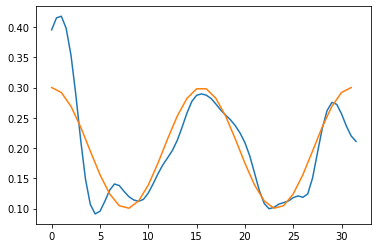

In [127]:
import matplotlib.pyplot as plt
tv_theta_ls = np.zeros(TVMAGI_theta_torch_LU.shape)
for thetaEachDim in range(TVMAGI_theta_torch_LU.shape[1]):
    TVMAGI_theta_torch = (KthetaluList[thetaEachDim] @ TVMAGI_theta_torch_LU.detach()[:, thetaEachDim]) + TV_theta_mean[thetaEachDim]
    theta_np = TVMAGI_theta_torch.numpy()
    tv_theta_ls[:, thetaEachDim] = theta_np.copy()
plt.plot(np.arange(0, 32, 0.5), tv_theta_ls[:, 2])
plt.plot(true_pd)

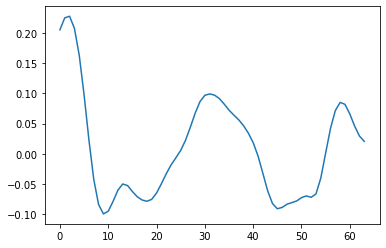

In [126]:
plt.plot(KthetaluList[2] @ TVMAGI_theta_torch_LU.detach()[:, 2])

In [125]:
inferred_theta

array([1.84631646, 0.10397016, 0.09924441, 0.19041272])

In [73]:
time_constant_param_ls

[tensor(0.0533, dtype=torch.float64, requires_grad=True)]

In [5]:
a = np.array([[1., 2,3,4]])
np.repeat(a, repeats=3, axis=0)

array([[1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.]])

# Package

In [2]:
import numpy as np
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi
from arma import matrix

# Derivatves of X according to the ODE structure
def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * theta[3] * theta[2]  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    resultDx = np.zeros(shape=[np.shape(x)[0], np.shape(x)[1], np.shape(x)[1]])
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (1) / dI
    resultDx[:, 2, 0] = -theta[0] * np.exp(logI) / N
    # (1) / dS, (1) /dE, (1) / dD = 0
    # (2) / dS
    resultDx[:, 0, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dE
    resultDx[:, 1, 1] = -theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dI
    resultDx[:, 2, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dD = 0
    # (3) / dS = 0
    # (3) / dE
    resultDx[:, 1, 2] = np.exp(logE - logI) * theta[1]
    # (3) / dI
    resultDx[:, 2, 2] = -np.exp(logE - logI) * theta[1]
    # (3) / dD = 0, (4) / dS, dE = 0
    # (4) / dI
    resultDx[:, 2, 3] = np.exp(logI - logD) * theta[3] * theta[2]
    # (4) / dD
    resultDx[:, 3, 3] = -np.exp(logI - logD) * theta[3] * theta[2]
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns derivation of theta given x
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    global N
    resultDtheta = np.zeros(shape=[np.shape(x)[0], np.shape(theta)[0], np.shape(x)[1]])
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程对theta_i求导
    # (1) / dRe
    resultDtheta[:, 0, 0] = -np.exp(logI) / N
    # (2) / d theta[0]
    resultDtheta[:, 0, 1] = np.exp(logS + logI - logE) / N
    # (2) / theta[1]
    resultDtheta[:, 1, 1] = -1.
    # (3) / dtheta[1]
    resultDtheta[:, 1, 2] = np.exp(logE - logI)
    # (3) / dtheta[2]
    resultDtheta[:, 2, 2] = -1.
    # (4) / theta[2]
    resultDtheta[:, 2, 3] = np.exp(logI - logD) * theta[3] 
    # (4) / theta[3]
    resultDtheta[:, 3, 3] = np.exp(logI - logD) * theta[2]
    return resultDtheta

def fOdeTorch(theta, x, constant_param_ls, KthetaluList=None):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    # LU decomposition
    if KthetasqrtList is not None:
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = (-KthetaluList[0] @ theta[:, 0]) * torch.exp(logI) / N  # (1)
        logEdt = (KthetaluList[0] @ theta[:, 0]) * torch.exp(logS + logI - logE) / N - (KthetaluList[1] @ theta[:, 1])  # (2)
        logIdt = torch.exp(logE - logI) * (KthetaluList[1] @ theta[:, 1]) - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * (KthetaluList[2] @ theta[:, 2]) * constant_param_ls[0]  # (4)
    else:       
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = -theta[:, 0] * torch.exp(logI) / N  # (1)
        logEdt = theta[:, 0] * torch.exp(logS + logI - logE) / N - theta[:, 1]  # (2)
        logIdt = torch.exp(logE - logI) * theta[:, 1] - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * theta[:, 2] * constant_param_ls[0]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature,
                                 obs_per_day):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


def MaternKernel(d, phi_1, phi_2):
    """
    construct a kernel given time points and hyper parameters
    """
    a = torch.square(phi_1) * (
            1. + np.sqrt(5) * d / phi_2 + 5. * torch.square(d) / (3. * torch.square(phi_2))) * torch.exp(
        -np.sqrt(5) * d / phi_2)
    return a.double()


def kernelllik(phi_1, phi_2, sigma, y, d_matrix, phi1_lb=0.1, phi2_lb=10.):
    """
    optimize the kernel hyperparameters by maximizing marginal likelihood
    """
    phi_1_bounded = torch.clamp(phi_1, min=phi1_lb)
    phi_2_bounded = torch.clamp(phi_2, min=phi2_lb)
    K = MaternKernel(d_matrix, phi_1, phi_2)
    K += torch.square(sigma) * torch.eye(y.shape[0]).double()
    return -y.shape[0] * np.log(np.sqrt(2 * np.pi)) - 0.5 * y @ torch.inverse(K) @ y - 0.5 * torch.logdet(
        K) - 1e8 * torch.square(phi_1 - phi_1_bounded) - 1e6 * torch.square(phi_2 - phi_2_bounded)

def fOdeTorch(theta_LU, x, constant_param_ls, TV_theta_mean=None, KthetaluList=None):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    N = 100000
    # LU decomposition
    if KthetaluList is not None:
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = -(KthetaluList[0] @ theta_LU[:, 0] + TV_theta_mean[0]) * torch.exp(logI) / N  # (1)
        logEdt = (KthetaluList[0] @ theta_LU[:, 0] + TV_theta_mean[0]) * torch.exp(logS + logI - logE) / N - (KthetaluList[1] @ theta_LU[:, 1] + TV_theta_mean[1])  # (2)
        logIdt = torch.exp(logE - logI) * (KthetaluList[1] @ theta_LU[:, 1] + TV_theta_mean[1]) - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * (KthetaluList[2] @ theta_LU[:, 2] + TV_theta_mean[2]) * constant_param_ls[0]  # (4)
    else:       
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = -theta_LU[:, 0] * torch.exp(logI) / N  # (1)
        logEdt = theta_LU[:, 0] * torch.exp(logS + logI - logE) / N - theta_LU[:, 1]  # (2)
        logIdt = torch.exp(logE - logI) * theta_LU[:, 1] - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * theta_LU[:, 2] * constant_param_ls[0]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)

def xthetasigmallikTorch(xlatent, theta_LU, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                         priorTemperature, KthetaluList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta_LU.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta_LU, xlatent, time_constant_param_ls, inferred_theta, KthetaluList)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    res2 = torch.zeros(1).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(torch.square(theta_LU[:, thetaEachDim]-inferred_theta[thetaEachDim]))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return torch.sum(res) + torch.sum(res_theta)


def TVMAGI_solver(obs_per_day=1,
                  discretization=2,
                  theta_lowerbound=np.array([0., 0., 0., 0.]),
                  theta_upperbound=np.array([np.inf, 1., 1., 1.]),
                  MAGI_niter=15001,
                  param_names = ['re', 've', 'vi', 'pd'],
                  is_time_varying=[True, True, False, True],
                  pointwise_niter=150000,
                  kernel_niter=60000,
                  TVMAGI_niter=100000,
                  phi1_lb_ls=np.array([0.1, 0.1, 0.1]),
                  phi2_lb_ls=np.array([0.1, 0.1, 0.1]),
                  use_trajectory='inferred',
                  learning_rate=np.array([1e-5, 1e-3, 1e-4])):
    
    nobs, p_dim = yobs.shape[0], yobs.shape[1]
    days = nobs / obs_per_day
    n_points = nobs * discretization
    theta_dim = theta_lowerbound.shape[0]
    d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
    for i in range(n_points):
        for j in range(n_points):
            if i > j:
                d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
            else:
                d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
    Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                             thetaLowerBound=theta_lowerbound,
                             thetaUpperBound=theta_upperbound)
    tvecObs = np.arange(0, days, 1. / obs_per_day)
    tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
    yFull = np.ndarray([n_points, p_dim])
    yFull.fill(np.nan)
    yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
    xInitExogenous = np.zeros_like(yFull)
    # interpolate: find the ydata of tvecFull given observations
    for i in range(p_dim):
        xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
    # First stage: use MAGI package to optimize theta as constant
    result = solve_magi(
        yFull,
        Ode_system,
        tvecFull,
        sigmaExogenous=np.array([]),
        phiExogenous=np.array([[]]),
        xInitExogenous=xInitExogenous,
        thetaInitExogenous=np.array([]),
        muExogenous=np.array([[]]),
        dotmuExogenous=np.array([[]]),
        priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
        priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
        priorTemperatureObs=1.0,
        kernel="generalMatern",
        nstepsHmc=100,
        burninRatioHmc=0.5,
        niterHmc=MAGI_niter,
        stepSizeFactorHmc=0.01,
        nEpoch=1,
        bandSize=40,
        useFrequencyBasedPrior=True,
        useBand=False,
        useMean=False,
        useScalerSigma=False,
        useFixedSigma=False,
        verbose=True)
    samplesCpp = result['samplesCpp']
    llikId = 0
    xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
    # dimension of theta
    thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
    sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
    burnin = int(MAGI_niter * 0.5)
    xsampled = samplesCpp[xId, (burnin + 1):]
    xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
    CovAllDimensionsPyList = []
    thetaSampled = samplesCpp[thetaId, (burnin + 1):]
    inferred_theta = np.mean(thetaSampled, axis=-1)
    sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
    inferred_sigma = np.mean(sigmaSampled, axis=-1)
    inferred_trajectory = np.mean(xsampled, axis=-1)
    for each_gpcov in result['result_solved'].covAllDimensions:
            each_pycov = dict(
                Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
                Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
                mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
            )
            CovAllDimensionsPyList.append(each_pycov)
            
    # Second stage, pointwise estimation of theta
    TV_theta_mean = np.zeros(int(sum(is_time_varying)))
    tv_index = 0
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == True:
            TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
            tv_index += 1

    if use_trajectory == 'observation':
        pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
    elif use_trajectory == 'inferred':
        pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
    else:
        raise ValueError
    tmp1 = np.array([TV_theta_mean])
    initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
    pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
    sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
    time_constant_param_ls = []
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == 0:
            param_name = param_names[thetaEachDim]
            locals()[param_name] = torch.tensor(inferred_theta[thetaEachDim], requires_grad=True, dtype=torch.double)
            time_constant_param_ls.append(eval(param_name))

    ydata = torch.from_numpy(yFull).double()
    priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
    pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=learning_rate[0])  # , weight_decay = 1.0
    for epoch in range(pointwise_niter):
        pointwise_optimizer.zero_grad()
        # compute loss function
        llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                            TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature, obs_per_day)
        loss = -llik
        if epoch % 100 == 0:
            print(epoch, loss.item())
        # compute gradient and update parameters
        #     if loss < -345. and epoch > 50000:
        #         break
        loss.backward()
        pointwise_optimizer.step()
        
    pointwise_theta = pointwise_theta_torch.detach().numpy()
    hyperparamList = []
    # optimize the hyperparameters of kernels
    for thetaEachDimension in range(pointwise_theta.shape[1]):
        phi_1 = torch.tensor(1., requires_grad=True, dtype=torch.double)
        phi_2 = torch.tensor(20.0, requires_grad=True, dtype=torch.double)
        sigma = torch.tensor(0.001, requires_grad=True, dtype=torch.double)
        kernel_optimizer = torch.optim.Adam([phi_1, phi_2, sigma], lr=learning_rate[1])
        for epoch in range(kernel_niter):
            kernel_optimizer.zero_grad()
            loss = -kernelllik(phi_1, 
                               phi_2, 
                               sigma, 
                               pointwise_theta_torch[:, thetaEachDimension] - torch.mean(pointwise_theta_torch[:, thetaEachDimension]), 
                               d_matrix, 
                               phi1_lb_ls[thetaEachDimension], 
                               phi2_lb_ls[thetaEachDimension])
            loss.backward()
            kernel_optimizer.step()
            if epoch % 100 == 0:
                print(epoch, loss.item())
        print(phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item())
        hyperparamList.append([phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()])

    KthetaList = []
    KthetaluList = []
    KinvthetaList = []
    KinvthetaluList = []
    for thetaEachDimension in range(pointwise_theta.shape[1]):
        ker = MaternKernel(d_matrix, torch.tensor(hyperparamList[thetaEachDimension][0]), torch.tensor(hyperparamList[thetaEachDimension][1]))
        KthetaList.append(ker)
        L_mat = torch.cholesky(ker)
        KthetaluList.append(L_mat)
        L_inv = torch.inverse(L_mat)
        KinvthetaluList.append(L_inv)
        
    TVMAGI_xlatent_torch = torch.tensor(pointwise_xlatent_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
    TVMAGI_theta_torch = torch.tensor(pointwise_theta_torch.detach().numpy(), dtype=torch.double)
    TVMAGI_theta_torch_LU = torch.zeros(TVMAGI_theta_torch.shape).double()
    for thetaEachDim in range(TVMAGI_theta_torch.shape[1]):
        TVMAGI_theta_torch_LU[:, thetaEachDim] = KinvthetaluList[thetaEachDim] @ (TVMAGI_theta_torch[:, thetaEachDim] - inferred_theta[thetaEachDim])
    TVMAGI_theta_torch_LU.requires_grad = True
    TVMAGI_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
    TVMAGI_optimizer = torch.optim.Adam([TVMAGI_xlatent_torch, TVMAGI_theta_torch_LU, TVMAGI_sigma_torch] + time_constant_param_ls, lr=learning_rate[2])
    for epoch in range(TVMAGI_niter):
        TVMAGI_optimizer.zero_grad()
        # compute loss function
        llik = xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch_LU, time_constant_param_ls, TVMAGI_sigma_torch,
                                                    TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                    priorTemperature, KthetaluList)
        loss = -llik
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        TVMAGI_optimizer.step()
    
    tv_theta_ls = np.zeros(TVMAGI_theta_torch_LU.shape)
    for thetaEachDim in range(TVMAGI_theta_torch_LU.shape[1]):
        TVMAGI_theta_torch = (KthetaluList[thetaEachDim] @ TVMAGI_theta_torch_LU.detach()[:, thetaEachDim]) + TV_theta_mean[thetaEachDim]
        theta_np = TVMAGI_theta_torch.numpy()
        tv_theta_ls[:, thetaEachDim] = theta_np.copy()
    
#     param_dict = {}
#     constant_index, tv_index = 0, 0
#     for thetaEachDim in range(theta_dim):
#         if is_time_varying[thetaEachDim] == True:
#             param_dict[param_names[thetaEachDim]] = tv_theta_ls[:, tv_index].copy()
#             tv_index += 1
#         else:
#             param_dict[param_names[thetaEachDim]] = time_constant_param_ls[constant_index].item()
#             constant_index += 1
    return tv_theta_ls, time_constant_param_ls

In [3]:
a, b = TVMAGI_solver(obs_per_day=1,
                  discretization=2,
                  theta_lowerbound=np.array([0., 0., 0., 0.]),
                  theta_upperbound=np.array([np.inf, 1., 1., 1.]),
                  MAGI_niter=15001,
                  param_names = ['re', 've', 'vi', 'pd'],
                  is_time_varying=[True, True, False, True],
                  pointwise_niter=150000,
                  kernel_niter=60000,
                  TVMAGI_niter=100000,
                  phi1_lb_ls=np.array([0.1, 0.1, 0.1]),
                  phi2_lb_ls=np.array([0.1, 0.1, 0.1]),
                  use_trajectory='inferred',
                  learning_rate=np.array([1e-5, 1e-3, 1e-3]))

0 -95.89162522619533


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


100 -128.4379605213447
200 -131.1606111513363
300 -131.44630763245578
400 -131.6698000103461
500 -131.88498785792623
600 -132.09587448112836
700 -132.3038634786692
800 -132.5099801621835
900 -132.7151300225027
1000 -132.92012587801554
1100 -133.12568504219172
1200 -133.33242815116444
1300 -133.54090132984817
1400 -133.75157548184956
1500 -133.9648586280438
1600 -134.18110734369898
1700 -134.40064032135822
1800 -134.62374559523442
1900 -134.85067499384076
2000 -135.08165025267402
2100 -135.31687684553648
2200 -135.55653025346965
2300 -135.80075867354628
2400 -136.0496977440463
2500 -136.3034581236237
2600 -136.5621285149665
2700 -136.82578777005534
2800 -137.0944860148776
2900 -137.36825947169316
3000 -137.64714333146105
3100 -137.9311486453879
3200 -138.22026456659103
3300 -138.51448236050504
3400 -138.8137707090167
3500 -139.1180753856251
3600 -139.42735673405855
3700 -139.74154800913198
3800 -140.06055141986758
3900 -140.3842824885361
4000 -140.71263526343967
4100 -141.04549300908138

32500 -271.0960090446129
32600 -271.67172985509296
32700 -272.2455559718953
32800 -272.81739401346454
32900 -273.3871680471055
33000 -273.95480234276295
33100 -274.52020265048293
33200 -275.0832993841864
33300 -275.6440134009428
33400 -276.2022374307511
33500 -276.7578848046925
33600 -277.3108771650817
33700 -277.86109280195296
33800 -278.40845481619283
33900 -278.9528425334989
34000 -279.4941532784314
34100 -280.0322714409316
34200 -280.5670851775056
34300 -281.0984760723838
34400 -281.62632983187075
34500 -282.15051940213914
34600 -282.67092317206055
34700 -283.18740235775704
34800 -283.6998625751527
34900 -284.2081140200575
35000 -284.7121043100214
35100 -285.21166028455735
35200 -285.70661815040245
35300 -286.196869568978
35400 -286.682236381119
35500 -287.1626409292244
35600 -287.6378856850565
35700 -288.10783650405835
35800 -288.57234154415494
35900 -289.0312727177569
36000 -289.4844928337625
36100 -289.93186096055166
36200 -290.3732590499884
36300 -290.8085677806668
36400 -291.2

64800 -354.3899012319774
64900 -354.6228115428192
65000 -354.85604769664064
65100 -355.08959152967907
65200 -355.3234611104308
65300 -355.5576395106445
65400 -355.7921088884793
65500 -356.0269182417212
65600 -356.26201627352054
65700 -356.4974111951893
65800 -356.7331174419526
65900 -356.96910959535444
66000 -357.205349272557
66100 -357.44198641040873
66200 -357.67885082918326
66300 -357.91600220416103
66400 -358.1534377873004
66500 -358.3911483551918
66600 -358.6291200627651
66700 -358.8673614261411
66800 -359.1059076637168
66900 -359.344695323336
67000 -359.58374013302745
67100 -359.8230099175423
67200 -360.0625707042138
67300 -360.30239390794765
67400 -360.5424460876708
67500 -360.7827138197114
67600 -361.0232491227692
67700 -361.26399538582933
67800 -361.50498837715963
67900 -361.7461921041352
68000 -361.9876149087691
68100 -362.22924665560106
68200 -362.47109805406546
68300 -362.71315202554683
68400 -362.955405439986
68500 -363.1978547757584
68600 -363.4404914400162
68700 -363.683

97100 -419.3840516170302
97200 -419.4702131140706
97300 -419.5554621107518
97400 -419.6397269916888
97500 -419.72304718114157
97600 -419.8054115077949
97700 -419.88682020560236
97800 -419.9672333839239
97900 -420.04677780142174
98000 -420.12531996978447
98100 -420.2029091436001
98200 -420.27956924351895
98300 -420.35526751657085
98400 -420.4300069943006
98500 -420.5038093065815
98600 -420.5766594779908
98700 -420.6485860593881
98800 -420.7195343672778
98900 -420.7896111207014
99000 -420.858717367685
99100 -420.92692100328736
99200 -420.9941985993349
99300 -421.0605618731021
99400 -421.12601282989914
99500 -421.19051527903946
99600 -421.25419613652434
99700 -421.31690338192817
99800 -421.3788699271883
99900 -421.43987945395713
100000 -421.50002453757264
100100 -421.55931078125684
100200 -421.6177400100804
100300 -421.6753294996555
100400 -421.73207835891674
100500 -421.78800030968466
100600 -421.8430907157333
100700 -421.89738535737837
100800 -421.95086682209535
100900 -422.003545315059

128400 -425.41696366809504
128500 -425.4169567239556
128600 -425.4169645048602
128700 -425.41693972013877
128800 -425.4169259041561
128900 -425.4169584966304
129000 -425.4169590405152
129100 -425.41696278752397
129200 -425.4169646763156
129300 -425.4169615080502
129400 -425.41696296406303
129500 -425.4169648932184
129600 -425.41695599163813
129700 -425.4169487994865
129800 -425.41695666722916
129900 -425.4169641014537
130000 -425.41693554412495
130100 -425.4169620905779
130200 -425.4169610121028
130300 -425.41696460138655
130400 -425.4169537903997
130500 -425.416963968499
130600 -425.41696269521304
130700 -425.4169578343271
130800 -425.4169562297288
130900 -425.41696357166904
131000 -425.4169638868116
131100 -425.4169639468684
131200 -425.4169626793155
131300 -425.4169631619104
131400 -425.4169606219035
131500 -425.41695505576035
131600 -425.41696425913267
131700 -425.4169608776143
131800 -425.4169628145277
131900 -425.41695498189927
132000 -425.4169602765952
132100 -425.4169517629895


10500 -34.41066451796897
10600 -34.619873529524014
10700 -34.82185406688973
10800 -35.016899316527514
10900 -35.205293854967536
11000 -35.38731461009192
11100 -35.56323164729919
11200 -35.733308804661235
11300 -35.897804207942315
11400 -36.056970695481624
11500 -36.211056184913275
11600 -36.36030400861078
11700 -36.50495324113544
11800 -36.64523903808961
11900 -36.78139300163676
12000 -36.91364358469568
12100 -37.042216544161164
12200 -37.16733545198407
12300 -37.28922227375541
12400 -37.408098025574475
12500 -37.52418351997197
12600 -37.63770021771501
12700 -37.748871201774875
12800 -37.857922298535925
12900 -37.96508337265459
13000 -38.070589835569024
13100 -38.1746844098499
13200 -38.277619212591674
13300 -38.37965823235291
13400 -38.48108029910699
13500 -38.58218267770269
13600 -38.68328545366347
13700 -38.784736940184956
13800 -38.88692040675326
13900 -38.990262542203155
14000 -39.09524421244811
14100 -39.20241428806
14200 -39.31240762526281
14300 -39.42596873860005
14400 -39.5439

43400 -97.28689595704941
43500 -97.28689592886927
43600 -97.28689595695178
43700 -97.28644300536789
43800 -97.28689585935528
43900 -97.28689556236148
44000 -97.28689595702104
44100 -97.28689595660268
44200 -97.28688112351216
44300 -97.28689594631946
44400 -97.28689595690676
44500 -97.28689594984318
44600 -97.28585669357415
44700 -97.2868957146984
44800 -97.28689595687065
44900 -97.28689593760541
45000 -97.28689595544793
45100 -97.28689438725931
45200 -97.28689595680247
45300 -97.28689595697607
45400 -97.2868959446458
45500 -97.286844914077
45600 -97.28689595583262
45700 -97.2868958977559
45800 -97.28689595709129
45900 -97.28684658479693
46000 -97.28689593894634
46100 -97.28689595697689
46200 -97.2868959545491
46300 -97.28689029503127
46400 -97.28689572839885
46500 -97.28689595576073
46600 -97.28689595678075
46700 -97.28689595636021
46800 -97.28686233711875
46900 -97.28689592958469
47000 -97.28689595705052
47100 -97.28689587518512
47200 -97.28541425673853
47300 -97.2868957745051
47400 -

16100 -254.86801297682084
16200 -255.2288576165493
16300 -255.53236561162495
16400 -255.9057413572622
16500 -256.26208279677553
16600 -256.5755304715989
16700 -256.9840952731633
16800 -257.3467083727114
16900 -257.7305852346608
17000 -258.1154153923171
17100 -258.48096003838043
17200 -258.90212435198634
17300 -259.24307396979657
17400 -259.6835649289625
17500 -258.8149803707714
17600 -259.315510997858
17700 -259.57316229457047
17800 -259.81998598473075
17900 -259.2692131561083
18000 -259.8367951950462
18100 -259.8519586213159
18200 -259.1654271980657
18300 -259.75872087880714
18400 -259.6860910760911
18500 -259.6254156904719
18600 -259.54909175833217
18700 -259.532156426488
18800 -259.7181692188613
18900 -259.7708962975704
19000 -259.5989111040001
19100 -259.2941530995269
19200 -259.86575343956275
19300 -259.896298684012
19400 -259.8179212266891
19500 -259.48035101978735
19600 -259.43716213140783
19700 -259.5686916791638
19800 -259.84050635165124
19900 -259.29370172555866
20000 -259.82

48500 -259.7522139887587
48600 -259.6526241647708
48700 -259.41483700284425
48800 -259.7846525787078
48900 -259.63253231622195
49000 -259.65880078585826
49100 -259.7798275158503
49200 -259.8628469045833
49300 -259.88435608362676
49400 -258.90560518616394
49500 -259.6083606074202
49600 -259.89147079086604
49700 -259.39566619245375
49800 -259.7772181274237
49900 -259.9159426879822
50000 -259.64102241632247
50100 -259.86543963128184
50200 -259.304574075206
50300 -259.9000294495527
50400 -259.47798787271336
50500 -259.8960337564954
50600 -259.86016863010775
50700 -259.59349619132286
50800 -259.6646035974674
50900 -259.7306820978191
51000 -259.8652797098146
51100 -259.680037485149
51200 -259.5820429534909
51300 -259.28006568007277
51400 -259.84004146679655
51500 -259.50852235182197
51600 -259.849579911213
51700 -259.28160495046313
51800 -259.8387378929717
51900 -259.66040639036305
52000 -259.8645838154901
52100 -259.29558321893023
52200 -259.3965392937632
52300 -259.84602250783155
52400 -25

21300 -46.79984947519023
21400 -46.82081046199259
21500 -46.841773072245104
21600 -46.862734768899344
21700 -46.88369292769616
21800 -46.90464483320994
21900 -46.92558767492639
22000 -46.94651854334582
22100 -46.96743442610796
22200 -46.98833220412371
22300 -47.009208647714544
22400 -47.03006041275309
22500 -47.05088403680209
22600 -47.07167593524761
22700 -47.09243239743057
22800 -47.11314958277231
22900 -47.13382351689823
23000 -47.15445008776308
23100 -47.175025041781794
23200 -47.19554397997085
23300 -47.21600235410929
23400 -47.236395462928556
23500 -47.256718448339996
23600 -47.27696629171595
23700 -47.29713381023609
23800 -47.317215653319764
23900 -47.33720629916175
24000 -47.357100051394184
24100 -47.37689103590107
24200 -47.396573197814035
24300 -47.41614029872093
24400 -47.435585914125625
24500 -47.454903431198545
24600 -47.47408604686473
24700 -47.493126766281335
24800 -47.51201840176108
24900 -47.530753572207715
25000 -47.549324703133465
25100 -47.567724027339324
25200 -47.

54100 -94.25445994076358
54200 -94.25445959738853
54300 -94.25445997889642
54400 -94.25445997893604
54500 -94.25443045847442
54600 -94.25445997667822
54700 -94.25445997893578
54800 -94.2544597700282
54900 -94.25356435064359
55000 -94.2544599665527
55100 -94.25445996910487
55200 -94.25445997893702
55300 -94.25445875584137
55400 -94.25444419475373
55500 -94.25445997790568
55600 -94.2544598552094
55700 -94.25445997893466
55800 -94.25445995768035
55900 -94.25445876880687
56000 -94.25445997888892
56100 -94.2544599789357
56200 -94.25445068998762
56300 -94.25442258466938
56400 -94.2544599761824
56500 -94.25445997892461
56600 -94.25445995657611
56700 -94.25445997796852
56800 -94.25445995904272
56900 -94.25445221775604
57000 -94.25445997885359
57100 -94.25445997893625
57200 -94.2544579878211
57300 -94.2544446613143
57400 -94.25445997858714
57500 -94.25445997859333
57600 -94.25445997785421
57700 -94.25445997893569
57800 -94.25438291725725
57900 -94.254458829385
58000 -94.2544599789066
58100 -94.

26800 -297.7714503648322
26900 -297.8321606065098
27000 -297.8327680933081
27100 -297.7769232561839
27200 -297.8131466960898
27300 -297.84000050250694
27400 -297.8149303701167
27500 -297.83959921858326
27600 -297.82064077069697
27700 -297.8277700016796
27800 -297.8232688623764
27900 -297.8191082053667
28000 -297.77977442952266
28100 -297.82673910591654
28200 -297.8313747690471
28300 -297.7894980605238
28400 -297.58524968269575
28500 -297.7735679816865
28600 -297.4248201386345
28700 -297.83882001580355
28800 -297.8413289182033
28900 -297.82507723398834
29000 -297.81717226900787
29100 -297.8103972965321
29200 -297.8373522276886
29300 -297.8351648502313
29400 -297.8304219379603
29500 -297.84130960897943
29600 -297.46819049267987
29700 -297.8149976701789
29800 -297.8186677818794
29900 -297.65481604937935
30000 -297.8148956065049
30100 -297.8270633731565
30200 -297.7710180755018
30300 -297.81618275734854
30400 -297.8316942723129
30500 -297.82958472544556
30600 -297.8097343771634
30700 -297.

59200 -297.76427679005945
59300 -297.83494750076
59400 -297.8210607284742
59500 -297.84786437359287
59600 -297.81690880015174
59700 -297.8201964235829
59800 -297.8341925497012
59900 -297.8153395182594
60000 -297.8014322917672
60100 -297.7846058107327
60200 -297.8015468112904
60300 -297.82525224162174
60400 -297.839072599686
60500 -297.8358378854466
60600 -297.8224939800393
60700 -297.6941193607502
60800 -297.8300802617573
60900 -297.8340173088617
61000 -297.77986242907775
61100 -297.82754374812095
61200 -297.81387445947985
61300 -297.81790788590763
61400 -297.8373135629317
61500 -297.83836506183343
61600 -297.8323844469885
61700 -297.7250827982167
61800 -297.7993964745341
61900 -297.74295109763113
62000 -297.83428984035817
62100 -297.81717226098084
62200 -297.62743424232536
62300 -297.80729947786665
62400 -297.83740100047004
62500 -297.82655210251755
62600 -297.7603012550016
62700 -297.83044947603923
62800 -297.8328741941558
62900 -297.75774265523336
63000 -297.80550490312703
63100 -29

91500 -297.8077985280172
91600 -297.76339047646024
91700 -297.46609045968535
91800 -297.81006424250194
91900 -297.8052240330047
92000 -297.80396953473354
92100 -297.77391856423003
92200 -297.7955202386521
92300 -297.8344495087305
92400 -297.5760881415984
92500 -297.7911894572426
92600 -297.56304861009795
92700 -297.7902921335567
92800 -297.8168632252575
92900 -297.81483188243726
93000 -297.7557979767304
93100 -297.8330283031078
93200 -297.79498045273715
93300 -297.821431945659
93400 -297.80959370299536
93500 -297.8129518324389
93600 -297.8371682459341
93700 -297.8271601061796
93800 -297.4618201144185
93900 -297.79427282321103
94000 -297.7863089355633
94100 -297.8221488291666
94200 -297.83313298027974
94300 -297.7166516482387
94400 -297.80993569192026
94500 -297.79941978562306
94600 -297.835251707402
94700 -297.79956245869124
94800 -297.73824103970276
94900 -297.75587543205893
95000 -297.6688268185679
95100 -297.7684953139152
95200 -297.82361206624023
95300 -297.83795049835146
95400 -29

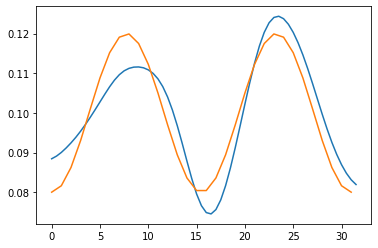

In [13]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, 32, 0.5), a[:, 1])
plt.plot(true_ve)

In [5]:
b

[tensor(0.0980, dtype=torch.float64, requires_grad=True)]